<a href="https://colab.research.google.com/github/gdiasbruno/finetune_retinaface/blob/main/Finetune_Retinaface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# different head finetune ClassHead

In [ ]:


!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large.pth'

In [ ]:
# use new weights against images in fold_4
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head.txt'

In [ ]:
def get_precision(true_positives, false_positives):
  denominador = (true_positives +  false_positives)

  if denominador == 0:
    return 0

  return true_positives/denominador

def get_recall(true_positives, false_negatives):
  return true_positives/(true_positives + false_negatives)


def get_false_negatives(true_positives, total_faces_number):
  return total_faces_number - true_positives

def calculate_iou(rect1, rect2):
    # Rectangles are represented as (x, y, width, height)

    # Calculate coordinates of the intersection rectangle
    x_inter = max(rect1[0], rect2[0])
    y_inter = max(rect1[1], rect2[1])
    width_inter = min(rect1[0] + rect1[2], rect2[0] + rect2[2]) - x_inter
    height_inter = min(rect1[1] + rect1[3], rect2[1] + rect2[3]) - y_inter

    # Check for non-overlapping rectangles
    if width_inter <= 0 or height_inter <= 0:
        return 0.0

    # Calculate areas of rectangles and intersection
    area_rect1 = rect1[2] * rect1[3]
    area_rect2 = rect2[2] * rect2[3]
    area_inter = width_inter * height_inter

    # Calculate IoU
    iou = area_inter / float(area_rect1 + area_rect2 - area_inter)

    return iou

In [ ]:
def get_false_positives_with_threshold(threshold, false_positives):
  count_false_positives = 0
  for pic_name, bbs in false_positives.items():
    for bb in bbs:
      conf = bb['conf']
      if conf >= threshold:
        count_false_positives = count_false_positives + 1

  return count_false_positives;

def get_true_positives_with_threshold(threshold, true_positives):
  count_true_positives = 0
  for pic_name, bbs in true_positives.items():
    for bb in bbs:
      conf = bb['conf']
      if conf >= threshold:
        count_true_positives = count_true_positives + 1

  return count_true_positives;

def calculate_precision_and_recall_per_threshold(threshold, all_faces, true_positives, false_positives):
  false_positives_per_threshold = get_false_positives_with_threshold(threshold, false_positives)
  true_positives_per_threshold = get_true_positives_with_threshold(threshold, true_positives)
  false_negatives = get_false_negatives(len(true_positives.items()), all_faces)

  precision = get_precision(true_positives_per_threshold, false_positives_per_threshold)
  recall = get_recall(true_positives_per_threshold, false_negatives)

  return precision, recall

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
len(all_pic_names_from_fold_4)

373

In [ ]:
len(pics_gt_malf_fold_4.items())

373

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
len(pics_predictions_malf_fold_4.items())

373

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
len(true_positives_fold_4['0010'])

3

In [ ]:
len(false_positives_fold_4['0010'])

1

In [ ]:
pics_predictions_malf_fold_4['0010']

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.581533868060997

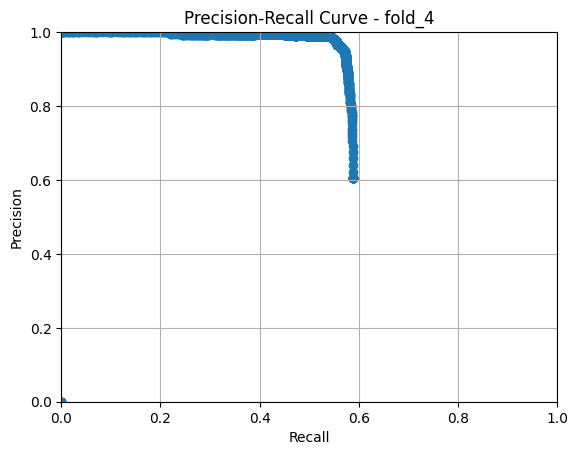

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# test 2 epochs

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_2_epochs.pth'

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_2_epochs.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_2_epochs.txt'

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_2_epochs.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
len(pics_predictions_malf_fold_4.items())

373

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5813493824860828

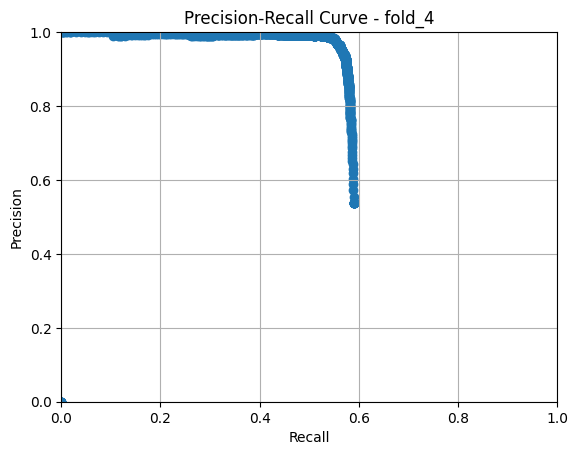

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# test 10 epochs batch size from 6 to 24


In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_10_epochs_24_batch.pth'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
ckpt_keys:  456
model_keys:  456
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Unfreezing  ClassHead.0.conv1x1.weight
Unfreezing  ClassHead.0.conv1x1.bias
Unfreezing  ClassHead.1.conv1x1.weight
Unfreezing  ClassHead.1.conv1x1.bias
Unfreezing  Cla

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_10_epochs_24_batch.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_10_epochs_24_batch.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_10_epochs_24_batch.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_10_epochs_24_batch.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
len(pics_predictions_malf_fold_4.items())

373

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5897009172487322

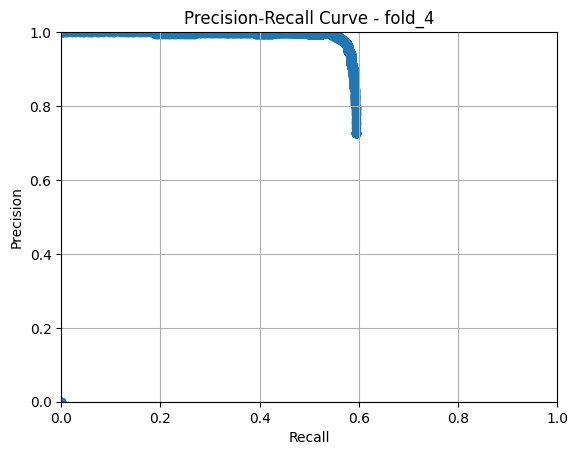

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# 1 epoch and 24 batch size

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_1_epochs_24_batch.pth'

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_1_epochs_24_batch.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_1_epochs_24_batch.txt'

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_1_epochs_24_batch.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5895112371754669

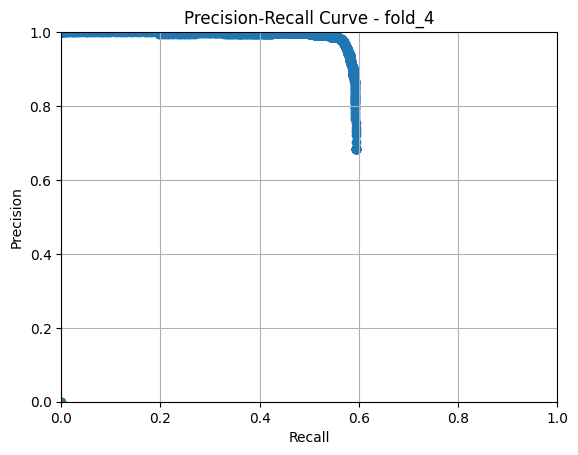

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

In [ ]:
[[356.4935302734375 ,46.14250946044922 ,402.0489807128906 ,85.86702728271484],
[240.76751708984375 ,84.12191772460938 ,282.5900573730469 ,125.4610366821289],
[53.70722961425781 ,83.2389907836914 ,76.68415069580078 ,106.4117202758789],
[152.42733764648438 ,111.20384979248047 ,181.9105224609375 ,142.36819458007812],]

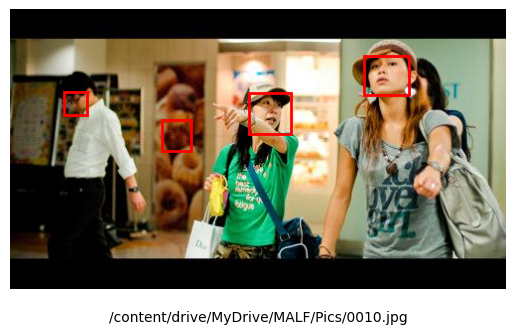

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load your image
img = Image.open('/content/drive/MyDrive/MALF/Pics/0010.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

bbs = [[356.4935302734375 ,46.14250946044922 ,402.0489807128906 ,85.86702728271484],
[240.76751708984375 ,84.12191772460938 ,282.5900573730469 ,125.4610366821289],
[53.70722961425781 ,83.2389907836914 ,76.68415069580078 ,106.4117202758789],
[152.42733764648438 ,111.20384979248047 ,181.9105224609375 ,142.36819458007812],]

for bb in bbs:
  rectangle = patches.Rectangle((bb[0], bb[1]), bb[2]- bb[0], bb[3]-bb[1], linewidth=2, edgecolor='r', facecolor='none')

  # Add the rectangle to the plot
  ax.add_patch(rectangle)

ax.axis('off')  # Turn off axis

# Add label using annotate for easy copy-pasting
ax.annotate('/content/drive/MyDrive/MALF/Pics/0010.jpg', xy=(0.5, -0.1), xycoords="axes fraction", ha="center", va="center")
# Show the plot
plt.show()

In [ ]:
[
[361.1650695800781 ,41.38994598388672 ,400.31890869140625 ,85.72994232177734],
[243.84402465820312 ,84.15089416503906 ,274.20245361328125 ,123.29308319091797],
[57.30805587768555 ,82.74320983886719 ,76.8603286743164 ,104.90846252441406],
[398.206787109375 ,60.93452835083008 ,420.63226318359375 ,97.0489730834961],
[146.88294982910156 ,60.462432861328125 ,165.45797729492188 ,83.92976379394531],
[157.11376953125 ,111.37332916259766 ,180.46939086914062 ,141.27305603027344],
[232.0582275390625 ,56.32905960083008 ,260.75555419921875 ,90.39795684814453],
[179.01434326171875 ,51.23371505737305 ,201.4192657470703 ,78.48734283447266],
[233.7805633544922 ,71.33914184570312 ,262.83966064453125 ,107.98372650146484],
[108.80554962158203 ,167.2408447265625 ,133.2986602783203 ,210.58108520507812],
[118.94448852539062 ,84.5964126586914 ,129.01747131347656 ,97.30514526367188],
[186.21087646484375 ,92.02342987060547 ,207.65496826171875 ,120.16629028320312],
[183.4213104248047 ,91.08867645263672 ,197.6284637451172 ,110.15630340576172],
[147.43849182128906 ,108.28436279296875 ,161.97021484375 ,127.25617980957031],
[164.68406677246094 ,89.81466674804688 ,181.3520965576172 ,108.37434387207031],
[170.3578338623047 ,83.0706558227539 ,186.1364288330078 ,101.8955078125],
[379.70782470703125 ,54.73492431640625 ,412.8489685058594 ,93.06195831298828],
[282.94000244140625 ,108.47054290771484 ,305.34613037109375 ,135.26718139648438],
[102.63455200195312 ,93.51374053955078 ,113.99948120117188 ,108.61068725585938],
[118.32810974121094 ,90.29389190673828 ,129.68394470214844 ,105.35005950927734],
[224.60983276367188 ,67.5679931640625 ,251.1133270263672 ,100.32742309570312],
[155.16189575195312 ,96.57353210449219 ,176.97705078125 ,123.02469635009766],
[108.7047119140625 ,92.7470474243164 ,119.50544738769531 ,106.46415710449219],
[149.12625122070312 ,98.95943450927734 ,164.16709899902344 ,118.42604064941406],
[153.6575469970703 ,70.32968139648438 ,170.48231506347656 ,91.46997833251953],
[115.11288452148438 ,117.21057891845703 ,129.87022399902344 ,136.83250427246094],]

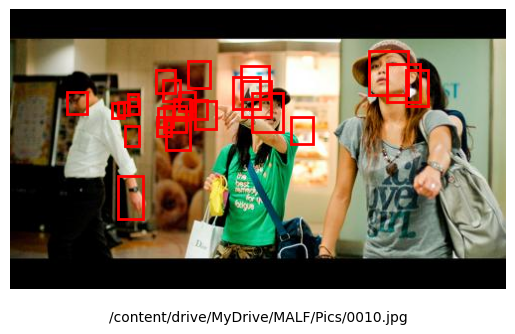

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load your image
img = Image.open('/content/drive/MyDrive/MALF/Pics/0010.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

bbs = [
[361.1650695800781 ,41.38994598388672 ,400.31890869140625 ,85.72994232177734],
[243.84402465820312 ,84.15089416503906 ,274.20245361328125 ,123.29308319091797],
[57.30805587768555 ,82.74320983886719 ,76.8603286743164 ,104.90846252441406],
[398.206787109375 ,60.93452835083008 ,420.63226318359375 ,97.0489730834961],
[146.88294982910156 ,60.462432861328125 ,165.45797729492188 ,83.92976379394531],
[157.11376953125 ,111.37332916259766 ,180.46939086914062 ,141.27305603027344],
[232.0582275390625 ,56.32905960083008 ,260.75555419921875 ,90.39795684814453],
[179.01434326171875 ,51.23371505737305 ,201.4192657470703 ,78.48734283447266],
[233.7805633544922 ,71.33914184570312 ,262.83966064453125 ,107.98372650146484],
[108.80554962158203 ,167.2408447265625 ,133.2986602783203 ,210.58108520507812],
[118.94448852539062 ,84.5964126586914 ,129.01747131347656 ,97.30514526367188],
[186.21087646484375 ,92.02342987060547 ,207.65496826171875 ,120.16629028320312],
[183.4213104248047 ,91.08867645263672 ,197.6284637451172 ,110.15630340576172],
[147.43849182128906 ,108.28436279296875 ,161.97021484375 ,127.25617980957031],
[164.68406677246094 ,89.81466674804688 ,181.3520965576172 ,108.37434387207031],
[170.3578338623047 ,83.0706558227539 ,186.1364288330078 ,101.8955078125],
[379.70782470703125 ,54.73492431640625 ,412.8489685058594 ,93.06195831298828],
[282.94000244140625 ,108.47054290771484 ,305.34613037109375 ,135.26718139648438],
[102.63455200195312 ,93.51374053955078 ,113.99948120117188 ,108.61068725585938],
[118.32810974121094 ,90.29389190673828 ,129.68394470214844 ,105.35005950927734],
[224.60983276367188 ,67.5679931640625 ,251.1133270263672 ,100.32742309570312],
[155.16189575195312 ,96.57353210449219 ,176.97705078125 ,123.02469635009766],
[108.7047119140625 ,92.7470474243164 ,119.50544738769531 ,106.46415710449219],
[149.12625122070312 ,98.95943450927734 ,164.16709899902344 ,118.42604064941406],
[153.6575469970703 ,70.32968139648438 ,170.48231506347656 ,91.46997833251953],
[115.11288452148438 ,117.21057891845703 ,129.87022399902344 ,136.83250427246094],]

for bb in bbs:
  rectangle = patches.Rectangle((bb[0], bb[1]), bb[2]- bb[0], bb[3]-bb[1], linewidth=2, edgecolor='r', facecolor='none')

  # Add the rectangle to the plot
  ax.add_patch(rectangle)

ax.axis('off')  # Turn off axis

# Add label using annotate for easy copy-pasting
ax.annotate('/content/drive/MyDrive/MALF/Pics/0010.jpg', xy=(0.5, -0.1), xycoords="axes fraction", ha="center", va="center")
# Show the plot
plt.show()

# 1 epoch 24 batch size ClassHead script


In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_script_fixed_24_batchsize.pth'

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_MALF_yaw_large_script_fixed_24_batchsize.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_script_fixed_24_batchsize.txt'

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_class_head_script_fixed_24_batchsize.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5280450940296613

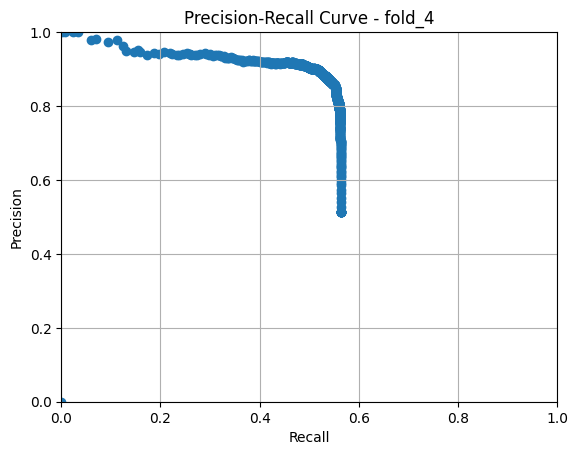

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# 1 epoch 24 batch size ClassHead.0.conv1x1.weight script fixed

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead.0.conv1x1.weight' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead.0.conv1x1.weight_MALF_yaw_large_script_fixed_24_batchsize.pth'

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead.0.conv1x1.weight_MALF_yaw_large_script_fixed_24_batchsize.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead.0.conv1x1.weight_script_fixed_24_batchsize.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead.0.conv1x1.weight_MALF_yaw_large_script_fixed_24_batchsize.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), paddi

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead.0.conv1x1.weight_script_fixed_24_batchsize.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.517472147342246

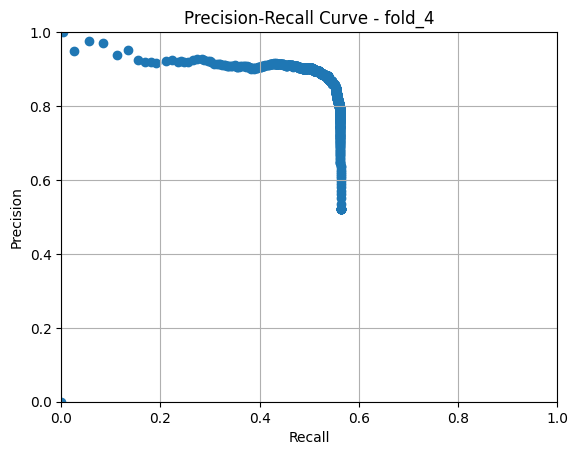

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# unfreeze it all for 1 epoch

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_0_1_2_3.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_all_unfreeze_yaw_large_script_fixed_24_batchsize.pth'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:00<00:00, 194MB/s]
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
ckpt_keys:  456
model_keys:  456
Missing keys:0
Unused checkpoint keys:0
Used key

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_all_unfreeze_yaw_large_script_fixed_24_batchsize.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_all_unfreeze_yaw_large_script_fixed_24_batchsize.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_all_unfreeze_yaw_large_script_fixed_24_batchsize.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=Fal

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_all_unfreeze_yaw_large_script_fixed_24_batchsize.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5866066131639531

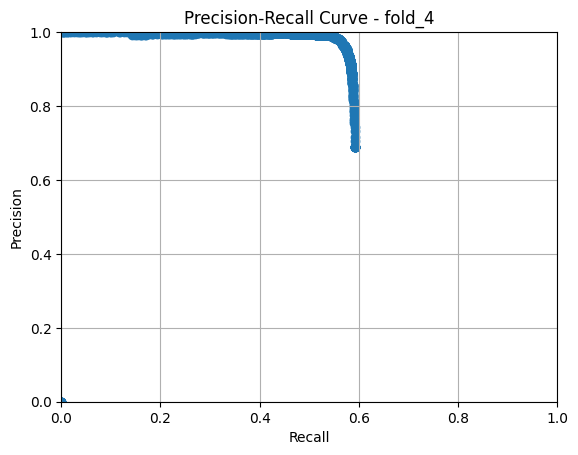

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

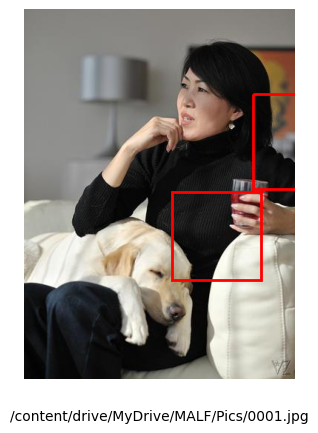

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Load your image
img = Image.open('/content/drive/MyDrive/MALF/Pics/0061.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

bbs = [[200, 246, 120, 120],
[309, 114, 128, 128],
[424, 99, 91, 91],
[601, 139, 106, 106]]

for bb in bbs:
  rectangle = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=2, edgecolor='r', facecolor='none')

  # Add the rectangle to the plot
  ax.add_patch(rectangle)

ax.axis('off')  # Turn off axis

# Add label using annotate for easy copy-pasting
ax.annotate('/content/drive/MyDrive/MALF/Pics/0001.jpg', xy=(0.5, -0.1), xycoords="axes fraction", ha="center", va="center")
# Show the plot
plt.show()

In [ ]:
!pip install labelme

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.3.1-py3-none-any.whl size=1472255 sha256=b97b26ae67416d3e0cc5f983804b8733d4f7f3002bf40e15479b2b282ed9a1dc
  Stored in directory: /root/.cache/pip/wheels/32/d6/4d/f22a84b8a82543c9db03774820

In [ ]:
!pip install pyqt

ERROR: Could not find a version that satisfies the requirement pyqt (from versions: none)
ERROR: No matching distribution found for pyqt


In [ ]:
!labelme /content/drive/MyDrive/MALF/Pics/0001.jpg -O /content/drive/MyDrive/MALF/new_annotations/0001.json

[INFO   ] __init__:get_config:70 - Loading config file from: /root/.labelmerc
QObject::moveToThread: Current thread (0x5c8e60255ff0) is not the object's thread (0x5c8e618f1080).
Cannot move to target thread (0x5c8e60255ff0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.



# re-label fold_0

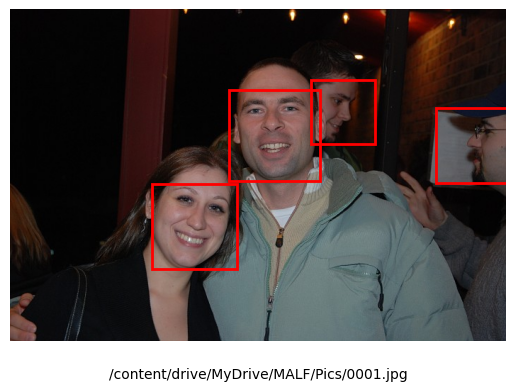

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Load your image
img = Image.open('/content/drive/MyDrive/MALF/Pics/0001.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

bbs = [[200, 246, 120, 120],
[309, 114, 128, 128],
[424, 99, 91, 91],
[601, 139, 106, 106]]
for bb in bbs:
  rectangle = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=2, edgecolor='r', facecolor='none')

  # Add the rectangle to the plot
  ax.add_patch(rectangle)

ax.axis('off')  # Turn off axis

# Add label using annotate for easy copy-pasting
ax.annotate('/content/drive/MyDrive/MALF/Pics/0001.jpg', xy=(0.5, -0.1), xycoords="axes fraction", ha="center", va="center")
# Show the plot
plt.show()

# finetune with one pic

The issue is that the model after all fine tune tries is losing a great amount of recall: dropping from 0.8 to < 0.6. My first hypothesis is that the labels from MALF have a great amount of background and that is maybe cuasing this effect. That is left to be tested.

I wat to test here a fine-tune with only one pic and only one layer unfronzen. I expetc to see the recall closer to non-fine tuned weights.

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_one_pic.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead.0.conv1x1.weight' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:00<00:00, 192MB/s]
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
ckpt_keys:  456
model_keys:  456
Missing keys:0
Unused checkpoint keys:0
Used key

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5423415787741694

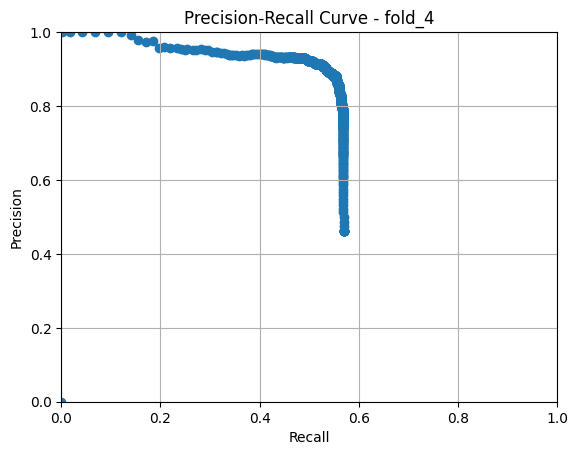

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# finetune 2 with different config

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune_2.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_one_pic.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='ClassHead.0.conv1x1.weight' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic_train_finetune_2.pth'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Loading Dataset...
Epoch:1/1 || Epochiter: 1/1 || Iter: 1/1 || Loc: 2.7414 Cla: 3.0270 || LR: 0.00000100 || Batchtime: 9.0987 s || ETA: 0:00:09
place_save /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_larg

In [ ]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic_train_finetune_2.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic_train_finetune_2.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic_train_finetune_2.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7,

In [ ]:
def convert_txybxy_xywh(bb):
  width = bb[2] - bb[0]
  height = bb[3] - bb[1]
  return [bb[0], bb[1], width, height]

pics_predictions_malf_fold_4 = {}

with open('/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_ClassHead_0_conv1x1_weight_MALF_yaw_large_script_fixed_24_batchsize_one_pic_train_finetune_2.txt', 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].split("/")[6].split(".")[0]
    pics_predictions_malf_fold_4[image_name] = []
    index = index + 1
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number
      bb_values_str = lines[face_index].split(" ")[:4]
      conf_lvl = lines[face_index].split(" ")[5].strip()
      bb = convert_txybxy_xywh([float(item) for item in bb_values_str])
      prediction_info = {
          'bb': bb,
          'conf': float(conf_lvl),
      }
      pics_predictions_malf_fold_4[image_name].append(prediction_info)

    index = index + int(number_of_faces.strip())

In [ ]:
file_path = '/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4.txt'

all_pic_names_from_fold_4 = []

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    all_pic_names_from_fold_4.append(line.strip())

In [ ]:
file_path = '/content/drive/MyDrive/MALF/rect_xywh_gt.txt'

pics_gt_malf_fold_4 = {}

with open(file_path, 'r') as file:
  lines = file.readlines()

  index = 0
  while index < len(lines):
    image_name = lines[index].strip()
    index = index + 1

    number_of_faces = lines[index]
    index = index + 1

    if image_name in all_pic_names_from_fold_4:
      pics_gt_malf_fold_4[image_name] = []

    for face_number in range(int(number_of_faces)):
      face_index = index + face_number

      if image_name in all_pic_names_from_fold_4:
        pics_gt_malf_fold_4[image_name].append([float(item.strip()) for item in lines[face_index].split(" ")])


    index = index + int(number_of_faces.strip())

In [ ]:
true_positives_fold_4 = {}
false_positives_fold_4 = {}

count = 0
for image_name in all_pic_names_from_fold_4:
  prediction_info_list = pics_predictions_malf_fold_4[image_name]
  for prediction_info in prediction_info_list:
    true_positive = False
    gts = pics_gt_malf_fold_4[image_name]

    for gt in gts:
      iou = calculate_iou(gt, prediction_info['bb'])
      if iou >= 0.5:
        true_positive = True

    if true_positive == True:
      true_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in true_positives_fold_4:
        true_positives_fold_4[image_name].append(true_positives_info)
      else:
        true_positives_fold_4[image_name] = [true_positives_info]
    else:
      false_positives_info = {
              'prediction_info': prediction_info,
              'conf': prediction_info['conf']
        }
      if image_name in false_positives_fold_4:
        false_positives_fold_4[image_name].append(false_positives_info)
      else:
        false_positives_fold_4[image_name] = [false_positives_info]

In [ ]:
count_all_faces_in_fold_4 = 0

for image_name, gts in pics_gt_malf_fold_4.items():
  count_all_faces_in_fold_4 = count_all_faces_in_fold_4 +  len(gts)

count_all_faces_in_fold_4

1092

In [ ]:
import numpy as np

conf_thresholds_1 = np.linspace(0.9, 0, 500)
conf_thresholds_2 = np.linspace(1, 0.9010101, 1500)

extended_conf_thresholds = np.append(conf_thresholds_2, conf_thresholds_1)

In [ ]:
precision_recall_curve_points_fold_4 = []

for threshold in extended_conf_thresholds:
  precision, recall = calculate_precision_and_recall_per_threshold(threshold, count_all_faces_in_fold_4, true_positives_fold_4, false_positives_fold_4)
  result = {
      'precision': precision,
      'recall': recall,
      'threshold': threshold
  }

  precision_recall_curve_points_fold_4.append(result)

In [ ]:
from sklearn.metrics import auc

recall_thresholds = [item['recall'] for item in precision_recall_curve_points_fold_4]
precision_thresholds = [item['precision'] for item in precision_recall_curve_points_fold_4]

auc_value = auc(recall_thresholds, precision_thresholds)
auc_value

0.5187680952353535

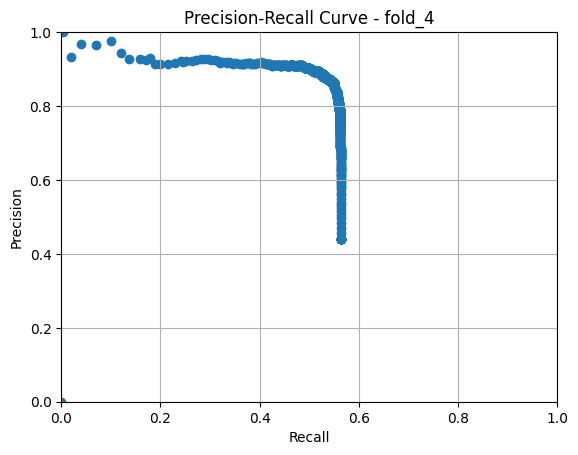

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x_values, y_values = zip(*points)
    plt.scatter(x_values, y_values, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - fold_4')

    # Set axis limits to go from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.grid(True)
    plt.show()

# Example usage:
points = [(item['recall'], item['precision']) for item in precision_recall_curve_points_fold_4]
plot_points(points)

# Change weights from LandmarkHead. Since I am not using LandMark output, this should result in not losing any recall

In [1]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/train_finetune.py --training_dataset='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/finetune_train_file_one_pic.txt' --network='resnet50' --pretrained_weights='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth' --unfreeze_layers='LandmarkHead' --output_weight_path='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_LandmarkHead_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:00<00:00, 116MB/s]
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Loading Dataset...
Epoch:1/1 || Epochiter: 1/1 || Iter: 1/1 || Loc: 2.3652 Cla: 3

In [2]:
!python3 /content/drive/MyDrive/Pytorch_Retinaface/detect_from_file_wider.py --trained_model='/content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_LandmarkHead_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth'  --input_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/fold_4_with_drive_path.txt' --output_file='/content/drive/MyDrive/fine_tune_scenarios/yaw_large/predictions_fold_4_finetune_weights_LandmarkHead_MALF_yaw_large_script_fixed_24_batchsize_one_pic.txt'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading pretrained model from /content/drive/MyDrive/Pytorch_Retinaface/weights/Resnet50_LandmarkHead_MALF_yaw_large_script_fixed_24_batchsize_one_pic.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3,